# Regresión logística

In [ ]:
!pip install statsmodels
!pip install pandas

In [ ]:
import pandas as pd

import statsmodels.api as sm
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 350)

from google.colab import auth
from google.cloud import bigquery

In [ ]:
auth.authenticate_user()

project_id = 'saltoproyecto3'
client = bigquery.Client(project=project_id)

query = """
SELECT *
FROM `saltoproyecto3.riesgorelativo.combined_view_lr`
"""

query_job = client.query(query)

df = query_job.to_dataframe()

df.head()

,user_id,number_dependents,age,last_month_salary,generation,...,loan_count,loan_group,m9do_group,dr_group,ulnspa_group
0,586,0,29,2500,q1,...,1,q1,q2,q4,q4
1,722,0,29,2500,q1,...,1,q1,q4,q4,q4
2,1450,4,45,4762,q2,...,1,q1,q3,q1,q4
3,1825,1,37,2975,q1,...,1,q1,q2,q1,q4
4,4104,1,33,3400,q1,...,1,q1,q3,q1,q4


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32586 entries, 0 to 32585
Data columns (total 14 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   user_id                                  32586 non-null  Int64  
 1   number_dependents                        32586 non-null  Int64  
 2   age                                      32586 non-null  Int64  
 3   last_month_salary                        32586 non-null  Int64  
 4   generation                               32586 non-null  object 
 5   default_flag                             32586 non-null  Int64  
 6   more_90_days_overdue                     32586 non-null  Int64  
 7   using_lines_not_secured_personal_assets  32586 non-null  float64
 8   debt_ratio                               32586 non-null  float64
 9   loan_count                               32586 non-null  Int64  
 10  loan_group                               32586

In [ ]:
data_categorical = df.select_dtypes(["object"]).astype("category")

In [ ]:
#reference level
print(data_categorical.apply(lambda x: x.cat.categories[0]))

generation         q1
loan_group         q1
m9do_group      other
dr_group           q1
ulnspa_group       q1
dtype: object


In [ ]:
df_dummies = pd.get_dummies(df, drop_first=True)

In [ ]:
df_dummies

,user_id,number_dependents,age,last_month_salary,default_flag,...,dr_group_q3,dr_group_q4,ulnspa_group_q2,ulnspa_group_q3,ulnspa_group_q4
0,586,0,29,2500,1,...,False,True,False,False,True
1,722,0,29,2500,1,...,False,True,False,False,True
2,1450,4,45,4762,1,...,False,False,False,False,True
3,1825,1,37,2975,1,...,False,False,False,False,True
4,4104,1,33,3400,1,...,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...
32581,14404,4,55,5000,0,...,False,True,False,False,False
32582,20571,4,57,9899,0,...,True,False,False,False,True
32583,6042,4,58,11010,0,...,False,False,False,False,False
32584,23729,4,60,10933,0,...,False,False,False,False,False


In [ ]:
df_dummies['intercept'] = 1

trains_col = df_dummies.drop('default_flag', axis=1)

In [ ]:
# Convertir las columnas booleanas a int (True a 1, False a 0)
trains_col = trains_col.astype({col: 'int' for col in trains_col.select_dtypes(include='bool').columns})

In [ ]:
# Asegurar que todas las columnas sean float
trains_col = trains_col.astype(float)
df_dummies['default_flag'] = df_dummies['default_flag'].astype(int)

In [ ]:
#Build Logistic Regression
logit = sm.Logit(df_dummies['default_flag'], trains_col)
output = logit.fit()

Optimization terminated successfully.
         Current function value: 0.032423
         Iterations 13


In [ ]:
output_table = pd.DataFrame(dict(coefficients = output.params, SE = output.bse,
                                 z = output.tvalues, p_values = output.pvalues))
#get coefficients and pvalues
print(output_table)

                                         coefficients        SE         z      p_values
user_id                                     -0.000007  0.000006 -1.298455  1.941309e-01
number_dependents                            0.073156  0.046868  1.560889  1.185499e-01
age                                         -0.009877  0.014583 -0.677289  4.982226e-01
last_month_salary                           -0.000206  0.000031 -6.683861  2.327281e-11
more_90_days_overdue                         0.114304  0.137656  0.830365  4.063325e-01
using_lines_not_secured_personal_assets     -0.000610  0.002875 -0.212242  8.319184e-01
debt_ratio                                   0.000003  0.000076  0.038758  9.690833e-01
loan_count                                   0.155866  0.046349  3.362880  7.713389e-04
generation_q2                                0.154730  0.235437  0.657204  5.110499e-01
generation_q3                               -0.293241  0.373913 -0.784250  4.328935e-01
generation_q4                   

In [ ]:
#only keep significant variables and order results by coefficient value
print(output_table.loc[output_table['p_values'] < 0.05].sort_values("coefficients", ascending=False))

                   coefficients        SE         z      p_values
ulnspa_group_q4        2.840489  0.378527  7.504054  6.187369e-14
dr_group_q3            0.699521  0.179314  3.901097  9.575791e-05
dr_group_q4            0.416177  0.201550  2.064881  3.893429e-02
loan_count             0.155866  0.046349  3.362880  7.713389e-04
last_month_salary     -0.000206  0.000031 -6.683861  2.327281e-11
m9do_group_q1         -5.912944  1.342285 -4.405132  1.057196e-05


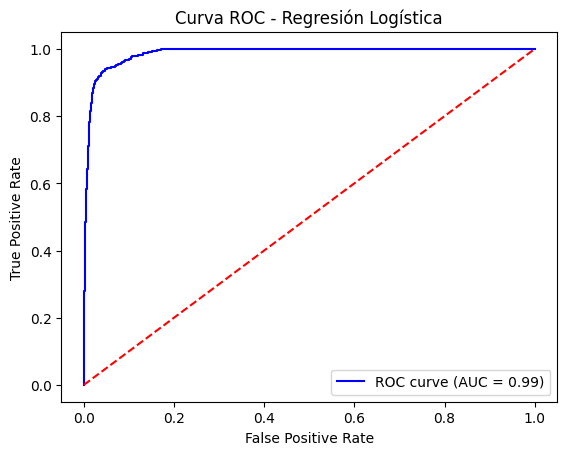

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Obtener las probabilidades predichas del modelo
y_pred_prob = output.predict(trains_col)

# Calcular la curva ROC y el AUC
fpr, tpr, thresholds = roc_curve(df_dummies['default_flag'], y_pred_prob)
roc_auc = roc_auc_score(df_dummies['default_flag'], y_pred_prob)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Línea diagonal de referencia
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Regresión Logística')
plt.legend(loc='lower right')
plt.show()


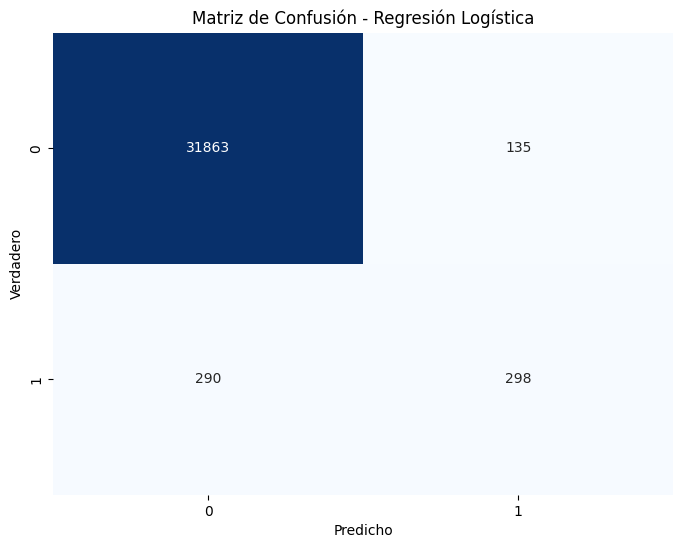

              precision    recall  f1-score   support

  No Default       0.99      1.00      0.99     31998
     Default       0.69      0.51      0.58       588

    accuracy                           0.99     32586
   macro avg       0.84      0.75      0.79     32586
weighted avg       0.99      0.99      0.99     32586



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Convertir las probabilidades predichas a 0 y 1 usando un umbral de 0.5
y_pred = (y_pred_prob >= 0.5).astype(int)

# Calcular la matriz de confusión
cm = confusion_matrix(df_dummies['default_flag'], y_pred)

# Graficar la matriz de confusión como un heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicho')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión - Regresión Logística')
plt.show()

# Imprimir el reporte de clasificación
report = classification_report(df_dummies['default_flag'], y_pred, target_names=['No Default', 'Default'])
print(report)
